# **PROJECT: CREDIT RISK ANALYSIS**

## **GOAL:** EDA to comment on factors of Credit Risk.
>
>"This case study aims to identify patterns which indicate if a client has difficulty paying their instalments which may be used for taking actions such as denying the loan, reducing the amount of the loan, lending (to risky applicants) at a higher interest rate, etc. This will ensure that the consumers capable of repaying the loan are not rejected. Identification of such applicants using EDA is the aim of this case study."
>
> #### **Potential Key Factors:**
>
> **Client Attributes:** Credit Score, Income, Employment, DTI Ratio, Credit History, Age, Marital Status
>
> **Loan Attributes:** Amount Type, Interest Term, LTV Ratio, Repayment History
>
> **Default Indicators:** Missed Payments, Debt Overload, Bankruptcy, Late Fees, Default Event

#### IMPORTING LIBRARIES
> Here, all the required libraries are being loaded.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# setup columns and rows for complete display

# to set max visible column to 200
pd.options.display.max_columns=200

# to set max visible rows to 200
pd.options.display.max_rows=200

# to make sure the data in a column is not truncated
pd.options.display.max_colwidth=None

# to get digits without exponential form
pd.set_option('display.float_format', lambda x: '%.6f' % x)

#### LOADING DATASETS
> Here, all the datasets are loaded into dataframes.

In [2]:
# load the datasets
df_application_data = pd.read_csv("application_data.csv")
df_columns_description = pd.read_csv("columns_description.csv", encoding="latin1")
df_previous_application = pd.read_csv("previous_application.csv")

In [3]:
# column name: SK_ID_PREV have a gap in df_columns_description, so it is being sorted.
df_columns_description.replace({"SK_ID_PREV ": "SK_ID_PREV"}, inplace=True)

## **0. PRELIMINARY STEP.**
## **NOTE**: RUNNING THE CELL BELOW TO CREATE **column_name()** FUNCTION
> This **FUNCTION** is created to get a quick glance of <u> descriptions of column names.

In [4]:
# function "column_name()" is made so that it can be called from anywhere.
def column_name(col):
    
    """
    The use of this function is to show the descriptions of column names along with 5 samples, if the column name is present in the dataset.
    """
    
    # here sample series of column names are shown.
    try:
        print()
        print("Previous Application, 5 random Samples:")
        print(df_previous_application[[col]].sample(5))
    except Exception:
        print(f"Column name: {col} is not present in df_previous_application")
        
    print()
    
    try:
        print("Current Application, 5 random Samples:")
        print(df_application_data[[col]].sample(5))
    except Exception:
        print(f"Column name: {col} is not present in df_application_data")
    
    print()
    
    print("COLUMN NAME DESCRIPTION:")
    return df_columns_description[["Table", "Row", "Description", "Special"]][df_columns_description["Row"]==col]

#### CALLING THE FUNCTION and PASSING A COLUMN NAME
> This cell below will call the function, **column_name()** and ask for a column name input.

In [5]:
# input a column name and call the function.
# NOTE: Default column name is given below. To check for a specific column name here, simply uncomment the section below and input the column name.
# This is done so that all the cells can be run from anywhere, at one go.
col = "SK_ID_CURR"
# col = input("Enter the column name to see description:")
column_name(col)


Previous Application, 5 random Samples:
         SK_ID_CURR
374130       430902
72999        282400
1464425      431584
1359554      194103
114556       233234

Current Application, 5 random Samples:
        SK_ID_CURR
140887      263352
287722      433284
304717      453036
90283       204812
221343      356402

COLUMN NAME DESCRIPTION:


,Table,Row,Description,Special
0,application_data,SK_ID_CURR,ID of loan in our sample,NaN
123,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed


# **1.**

## **WORKING ON "df_previous_application"**
> Using domain knowledge from internet, we came to know that:
> 
> <u> Columns to Keep Further:
> 
> **AMT_CREDIT:** This is the total loan amount granted, which is the central feature in any credit risk model. It is directly related to the applicant’s ability to repay. It’s one of the most important columns for understanding the financial commitment involved in the loan.
>
>**AMT_APPLICATION:** The amount requested by the applicant provides important context, especially when compared with the approved loan amount. This comparison can reveal discrepancies or patterns (e.g., applicants requesting more than they are granted).
>
>**AMT_ANNUITY:** The monthly repayment amount provides valuable insight into how manageable the loan is for the applicant. This helps in understanding their financial burden relative to their loan approval. It's essential for assessing the applicant's ability to repay over time.
>
>**CNT_PAYMENT:** The number of payments required to repay the loan is another key feature, as it directly impacts the duration of repayment. It’s also useful for understanding the loan term and its relationship with default risk.


In [6]:
# new list of columns
filtered_col = ['SK_ID_PREV', 'SK_ID_CURR', 'AMT_CREDIT', 'AMT_APPLICATION', 'AMT_ANNUITY', 'CNT_PAYMENT', 'NAME_CONTRACT_STATUS']

# creating filtered dataframe
df_filtered_previous_data = df_previous_application[filtered_col].copy()

# converting the approval status to numerical, so that we can get an aggregate value out of it.
def approval_func(column):

    """
    In this function, the column NAME_CONTRACT_STATUS has four types of data. 
    These are given values 1 for approved -1 for rejected and for other criteria, neutral value of 0.
    Finally, we can aggregate this to get a feel for the approval rate of an indivisual.
    """
    
    if column == "Approved":
        return 1
    elif column == "Refused":
        return -1
    else:
        return 0
df_filtered_previous_data["APPROVAL_NUMBER"] = df_filtered_previous_data["NAME_CONTRACT_STATUS"].apply(approval_func)

# this is the filtered dataframe
df_filtered_previous_data.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT,AMT_APPLICATION,AMT_ANNUITY,CNT_PAYMENT,NAME_CONTRACT_STATUS,APPROVAL_NUMBER
0,2030495,271877,17145.000000,17145.000000,1730.430000,12.000000,Approved,1
1,2802425,108129,679671.000000,607500.000000,25188.615000,36.000000,Approved,1
2,2523466,122040,136444.500000,112500.000000,15060.735000,12.000000,Approved,1
3,2819243,176158,470790.000000,450000.000000,47041.335000,12.000000,Approved,1
4,1784265,202054,404055.000000,337500.000000,31924.395000,24.000000,Refused,-1


#### **NOTE:** As there are multiple instances of repeated SK_ID_CURR because of previous application, we will group the filtered data by SK_ID_CURR and aggregate the above columns. This way we can finally merge the filtered dataset with SK_ID_CURR.

#### GROUPING DATAFRAME BY SK_ID_CURR

In [7]:
# create final column for aggregation
grouped_col = ["AMT_CREDIT_AGG", "AMT_APPLICATION_AGG", "AMT_ANNUITY_AGG", "CNT_PAYMENT_AGG", "APPROVAL_NUMBER_AGG"]

# grouping the columns indivisually and 
grp_credit = df_filtered_previous_data.groupby("SK_ID_CURR")["AMT_CREDIT"].mean()
grp_application = df_filtered_previous_data.groupby("SK_ID_CURR")["AMT_APPLICATION"].mean()
grp_annuity = df_filtered_previous_data.groupby("SK_ID_CURR")["AMT_ANNUITY"].mean()
grp_payment = df_filtered_previous_data.groupby("SK_ID_CURR")["CNT_PAYMENT"].mean()
# here sum is taken to get net value of acceptance.
grp_approval = df_filtered_previous_data.groupby("SK_ID_CURR")["APPROVAL_NUMBER"].sum()

df_final_prev = pd.DataFrame({"AMT_CREDIT_AGG":grp_credit, "AMT_APPLICATION_AGG":grp_application, "AMT_ANNUITY_AGG":grp_annuity, "CNT_PAYMENT_AGG":grp_payment, "APPROVAL_NUMBER_AGG":grp_approval}, columns = grouped_col)
# this is the filtered dataframe grouped by SK_ID_CURR
df_final_prev.head()


,AMT_CREDIT_AGG,AMT_APPLICATION_AGG,AMT_ANNUITY_AGG,CNT_PAYMENT_AGG,APPROVAL_NUMBER_AGG
SK_ID_CURR,,,,,
100001,23787.000000,24835.500000,3951.000000,8.000000,1
100002,179055.000000,179055.000000,9251.775000,24.000000,1
100003,484191.000000,435436.500000,56553.990000,10.000000,3
100004,20106.000000,24282.000000,5357.250000,4.000000,1
100005,20076.750000,22308.750000,4813.200000,12.000000,1


#### 1.1. DATA CLEANING

In [8]:
# checking the null values percentages
df_final_prev.isna().mean() * 100

AMT_CREDIT_AGG        0.000000
AMT_APPLICATION_AGG   0.000000
AMT_ANNUITY_AGG       0.141653
CNT_PAYMENT_AGG       0.141062
APPROVAL_NUMBER_AGG   0.000000
dtype: float64

In [9]:
# as the null values are quite low in grouped dataset, we will directly remove the rows
df_final_prev.dropna(inplace=True)

In [10]:
# checking again
df_final_prev.isna().mean() * 100

AMT_CREDIT_AGG        0.000000
AMT_APPLICATION_AGG   0.000000
AMT_ANNUITY_AGG       0.000000
CNT_PAYMENT_AGG       0.000000
APPROVAL_NUMBER_AGG   0.000000
dtype: float64

# 2.

## **WORKING ON "df_application_data"**
> Using the domain knowledge, and various online resources, we have distilled the most important columns into these segments.

1. **Demographic Information**
TARGET (Target variable for classification), 
CODE_GENDER (Gender), 
NAME_INCOME_TYPE (Income type: salaried, self-employed, etc.), 
NAME_EDUCATION_TYPE (Education level), 
NAME_FAMILY_STATUS (Family status: single, married, etc.), 
NAME_HOUSING_TYPE (Housing status: owns, rents, etc.), 
OCCUPATION_TYPE (Occupation of the applicant), 
CNT_FAM_MEMBERS (Number of family members).
2. **Financial Information**
NAME_CONTRACT_TYPE (Type of loan contract: cash loan, consumer credit, etc.), 
AMT_CREDIT (Loan amount), 
AMT_ANNUITY (Annuity or monthly payment amount), 
AMT_GOODS_PRICE (Price of the goods being purchased with the loan), 
AMT_INCOME_TOTAL (Total income of the applicant).
3. **Age and Employment Information**
DAYS_BIRTH (Age of the applicant in days), 
DAYS_EMPLOYED (Duration of employment in days), 
DAYS_REGISTRATION (Duration of residence registration in days), 
DAYS_ID_PUBLISH (Duration since the ID was published).
4. **Contact Information**
DAYS_LAST_PHONE_CHANGE (Duration since last phone number change).
5. **Asset Ownership**
FLAG_OWN_CAR (Whether the applicant owns a car), 
FLAG_OWN_REALTY (Whether the applicant owns real estate).
6. **Social Circle and Credit Bureau Information**
OBS_30_CNT_SOCIAL_CIRCLE (Count of social circle observations in the last 30 days), 
DEF_30_CNT_SOCIAL_CIRCLE (Count of defaults in the social circle in the last 30 days), 
AMT_REQ_CREDIT_BUREAU_HOUR (Credit bureau requests in the last hour), 
AMT_REQ_CREDIT_BUREAU_DAY (Credit bureau requests in the last day), 
AMT_REQ_CREDIT_BUREAU_MON (Credit bureau requests in the last month).

In [11]:
# segmenting columns into above groups for analysis in future.

demographic_col = ["CODE_GENDER", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS"]
financial_col = ["NAME_CONTRACT_TYPE", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL"]
employment_col = ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
contact_col = ["DAYS_LAST_PHONE_CHANGE"]
asset_col = ["FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
credit_bureau_col = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_MON"]
target_col = ["TARGET"]
# so total column is
total_col = target_col + demographic_col + financial_col + employment_col + contact_col + asset_col + credit_bureau_col

In [12]:
# setting the current id as key
df_application_data.set_index("SK_ID_CURR", inplace=True)

# NOTE: "SK_ID_CURR" is made as index so that the two dataframes can be merged on it.

#### 2.1. DATA CLEANING

In [13]:
df_application_data[total_col].isna().mean() * 100

TARGET                        0.000000
CODE_GENDER                   0.000000
NAME_INCOME_TYPE              0.000000
NAME_EDUCATION_TYPE           0.000000
NAME_FAMILY_STATUS            0.000000
NAME_HOUSING_TYPE             0.000000
OCCUPATION_TYPE              31.345545
CNT_FAM_MEMBERS               0.000650
NAME_CONTRACT_TYPE            0.000000
AMT_CREDIT                    0.000000
AMT_ANNUITY                   0.003902
AMT_GOODS_PRICE               0.090403
AMT_INCOME_TOTAL              0.000000
DAYS_BIRTH                    0.000000
DAYS_EMPLOYED                 0.000000
DAYS_REGISTRATION             0.000000
DAYS_ID_PUBLISH               0.000000
DAYS_LAST_PHONE_CHANGE        0.000325
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
OBS_30_CNT_SOCIAL_CIRCLE      0.332021
DEF_30_CNT_SOCIAL_CIRCLE      0.332021
AMT_REQ_CREDIT_BUREAU_HOUR   13.501631
AMT_REQ_CREDIT_BUREAU_DAY    13.501631
AMT_REQ_CREDIT_BUREAU_MON    13.501631
dtype: float64

**NOTE**:
> **Null values:**
> 
> In demographic_col: OCCUPATION_TYPE have 31.35% null values so we will impute with mode value.
> 
> In financial_col: All the columns have minimal null values(<0.1%) so we will ignore it.
> 
> In employment_col: There is no null values
> 
> In contact_col: There is 0.0003% null values so we will ignore it too.
> 
> In asset_col: There is no null value.
> 
> In credit_bureau_col: There are 13.5% null values in which we will impute with median.

In [14]:
# imputing OCCUPATION_TYPE with mode value
df_application_data.fillna({"OCCUPATION_TYPE":df_application_data["OCCUPATION_TYPE"].mode()[0]}, inplace=True)

In [15]:
# imputing MT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_MON with median values.
df_application_data.fillna({"AMT_REQ_CREDIT_BUREAU_HOUR":df_application_data["AMT_REQ_CREDIT_BUREAU_HOUR"].median()}, inplace=True)
df_application_data.fillna({"AMT_REQ_CREDIT_BUREAU_DAY":df_application_data["AMT_REQ_CREDIT_BUREAU_DAY"].median()}, inplace=True)
df_application_data.fillna({"AMT_REQ_CREDIT_BUREAU_MON":df_application_data["AMT_REQ_CREDIT_BUREAU_MON"].median()}, inplace=True)

#### Looking at the filtered datasets

In [16]:
df_application_data[total_col].head()

,TARGET,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,FLAG_OWN_CAR,FLAG_OWN_REALTY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,M,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.000000,Cash loans,406597.500000,24700.500000,351000.000000,202500.000000,-9461,-637,-3648.000000,-2120,-1134.000000,N,Y,2.000000,2.000000,0.000000,0.000000,0.000000
100003,0,F,State servant,Higher education,Married,House / apartment,Core staff,2.000000,Cash loans,1293502.500000,35698.500000,1129500.000000,270000.000000,-16765,-1188,-1186.000000,-291,-828.000000,N,N,1.000000,0.000000,0.000000,0.000000,0.000000
100004,0,M,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.000000,Revolving loans,135000.000000,6750.000000,135000.000000,67500.000000,-19046,-225,-4260.000000,-2531,-815.000000,Y,Y,0.000000,0.000000,0.000000,0.000000,0.000000
100006,0,F,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,2.000000,Cash loans,312682.500000,29686.500000,297000.000000,135000.000000,-19005,-3039,-9833.000000,-2437,-617.000000,N,Y,2.000000,0.000000,0.000000,0.000000,0.000000
100007,0,M,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,1.000000,Cash loans,513000.000000,21865.500000,513000.000000,121500.000000,-19932,-3038,-4311.000000,-3458,-1106.000000,N,Y,0.000000,0.000000,0.000000,0.000000,0.000000


# 3.

##  **MERGING df_application_data[total_col] and df_final_prev  on column "SK_ID_CURR"**

In [17]:
# merging all the datasets from both the filtered datasets, ensuring that we keep the current dataset rows intact.
df_merged = pd.merge(df_application_data[total_col], df_final_prev, left_index=True, right_index=True, how="left")

# finally reseting the index
df_merged.reset_index(inplace=True)

In [18]:
# finally looking at the final dataset
df_merged.head(5)

,SK_ID_CURR,TARGET,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,FLAG_OWN_CAR,FLAG_OWN_REALTY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_CREDIT_AGG,AMT_APPLICATION_AGG,AMT_ANNUITY_AGG,CNT_PAYMENT_AGG,APPROVAL_NUMBER_AGG
0,100002,1,M,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.000000,Cash loans,406597.500000,24700.500000,351000.000000,202500.000000,-9461,-637,-3648.000000,-2120,-1134.000000,N,Y,2.000000,2.000000,0.000000,0.000000,0.000000,179055.000000,179055.000000,9251.775000,24.000000,1.000000
1,100003,0,F,State servant,Higher education,Married,House / apartment,Core staff,2.000000,Cash loans,1293502.500000,35698.500000,1129500.000000,270000.000000,-16765,-1188,-1186.000000,-291,-828.000000,N,N,1.000000,0.000000,0.000000,0.000000,0.000000,484191.000000,435436.500000,56553.990000,10.000000,3.000000
2,100004,0,M,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.000000,Revolving loans,135000.000000,6750.000000,135000.000000,67500.000000,-19046,-225,-4260.000000,-2531,-815.000000,Y,Y,0.000000,0.000000,0.000000,0.000000,0.000000,20106.000000,24282.000000,5357.250000,4.000000,1.000000
3,100006,0,F,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,2.000000,Cash loans,312682.500000,29686.500000,297000.000000,135000.000000,-19005,-3039,-9833.000000,-2437,-617.000000,N,Y,2.000000,0.000000,0.000000,0.000000,0.000000,291695.500000,272203.260000,23651.175000,23.000000,4.000000
4,100007,0,M,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,1.000000,Cash loans,513000.000000,21865.500000,513000.000000,121500.000000,-19932,-3038,-4311.000000,-3458,-1106.000000,N,Y,0.000000,0.000000,0.000000,0.000000,0.000000,166638.750000,150530.250000,12278.805000,20.666667,6.000000


## 3.1. DATA CLEANING ON FINAL DATAFRAME

In [19]:
# looking at percentage of null values
df_merged.isna().mean() * 100

SK_ID_CURR                   0.000000
TARGET                       0.000000
CODE_GENDER                  0.000000
NAME_INCOME_TYPE             0.000000
NAME_EDUCATION_TYPE          0.000000
NAME_FAMILY_STATUS           0.000000
NAME_HOUSING_TYPE            0.000000
OCCUPATION_TYPE              0.000000
CNT_FAM_MEMBERS              0.000650
NAME_CONTRACT_TYPE           0.000000
AMT_CREDIT                   0.000000
AMT_ANNUITY                  0.003902
AMT_GOODS_PRICE              0.090403
AMT_INCOME_TOTAL             0.000000
DAYS_BIRTH                   0.000000
DAYS_EMPLOYED                0.000000
DAYS_REGISTRATION            0.000000
DAYS_ID_PUBLISH              0.000000
DAYS_LAST_PHONE_CHANGE       0.000325
FLAG_OWN_CAR                 0.000000
FLAG_OWN_REALTY              0.000000
OBS_30_CNT_SOCIAL_CIRCLE     0.332021
DEF_30_CNT_SOCIAL_CIRCLE     0.332021
AMT_REQ_CREDIT_BUREAU_HOUR   0.000000
AMT_REQ_CREDIT_BUREAU_DAY    0.000000
AMT_REQ_CREDIT_BUREAU_MON    0.000000
AMT_CREDIT_A

**NOTE:**
> As we are going to perform EDA to get general insight on the data rather than give a remark on a particular client, so we will simply drop the null values (which we can see above are below 6%).

In [20]:
# dropping null values
df_merged.dropna(inplace=True)

In [21]:
# finally looking at count of null values
df_merged.isna().sum()

SK_ID_CURR                    0
TARGET                        0
CODE_GENDER                   0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
CNT_FAM_MEMBERS               0
NAME_CONTRACT_TYPE            0
AMT_CREDIT                    0
AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
AMT_INCOME_TOTAL              0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
DAYS_LAST_PHONE_CHANGE        0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
OBS_30_CNT_SOCIAL_CIRCLE      0
DEF_30_CNT_SOCIAL_CIRCLE      0
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_CREDIT_AGG                0
AMT_APPLICATION_AGG           0
AMT_ANNUITY_AGG               0
CNT_PAYMENT_AGG               0
APPROVAL_NUMBER_AGG           0
dtype: i

## 3.2. BROADER LOOK AT THE DATA

In [22]:
# shape
df_merged.shape

(289587, 31)

In [23]:
# info
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289587 entries, 0 to 307510
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  289587 non-null  int64  
 1   TARGET                      289587 non-null  int64  
 2   CODE_GENDER                 289587 non-null  object 
 3   NAME_INCOME_TYPE            289587 non-null  object 
 4   NAME_EDUCATION_TYPE         289587 non-null  object 
 5   NAME_FAMILY_STATUS          289587 non-null  object 
 6   NAME_HOUSING_TYPE           289587 non-null  object 
 7   OCCUPATION_TYPE             289587 non-null  object 
 8   CNT_FAM_MEMBERS             289587 non-null  float64
 9   NAME_CONTRACT_TYPE          289587 non-null  object 
 10  AMT_CREDIT                  289587 non-null  float64
 11  AMT_ANNUITY                 289587 non-null  float64
 12  AMT_GOODS_PRICE             289587 non-null  float64
 13  AMT_INCOME_TOTAL   

In [24]:
# description (numerical)
df_merged.describe()

,SK_ID_CURR,TARGET,CNT_FAM_MEMBERS,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_CREDIT_AGG,AMT_APPLICATION_AGG,AMT_ANNUITY_AGG,CNT_PAYMENT_AGG,APPROVAL_NUMBER_AGG
count,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000,289587.000000
mean,278187.775166,0.082069,2.160118,591830.305747,27028.455930,530992.140776,167144.603071,-16053.243802,64111.782746,-4993.937045,-2992.613101,-996.635764,1.427098,0.144958,0.005439,0.005808,0.235508,170285.909846,154188.062511,14532.515992,14.529862,2.205797
std,102831.488432,0.274470,0.913570,391766.062944,14093.716471,358422.918392,240593.619403,4356.213910,141535.170078,3518.451216,1510.217442,814.302070,2.410597,0.449554,0.077168,0.097842,0.859439,165800.332749,153351.618932,10007.574361,8.420448,2.373093
min,100002.000000,0.000000,1.000000,45000.000000,1615.500000,40500.000000,25650.000000,-25201.000000,-17912.000000,-24672.000000,-7197.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-64.000000
25%,189121.500000,0.000000,2.000000,270000.000000,16609.500000,238500.000000,112500.000000,-19688.000000,-2771.000000,-7485.000000,-4298.000000,-1595.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67005.000000,62043.525000,7836.210000,9.000000,1.000000
50%,278285.000000,0.000000,2.000000,509400.000000,24939.000000,450000.000000,144000.000000,-15767.000000,-1230.000000,-4513.000000,-3251.000000,-810.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117667.800000,106155.000000,11986.350000,12.000000,2.000000
75%,367229.500000,0.000000,3.000000,808650.000000,34587.000000,679500.000000,202500.000000,-12442.500000,-298.000000,-2028.000000,-1716.500000,-324.000000,2.000000,0.000000,0.000000,0.000000,0.000000,216287.700000,191337.525000,18329.906250,18.000000,3.000000
max,456255.000000,1.000000,20.000000,4050000.000000,225000.000000,4050000.000000,117000000.000000,-7489.000000,365243.000000,0.000000,0.000000,0.000000,348.000000,34.000000,4.000000,9.000000,27.000000,4050000.000000,4050000.000000,300425.445000,72.000000,22.000000


In [25]:
# description (categorical)
df_merged.describe(include="O")

,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY
count,289587,289587,289587,289587,289587,289587,289587,289587,289587
unique,3,7,5,5,6,18,2,2,2
top,F,Working,Secondary / secondary special,Married,House / apartment,Laborers,Cash loans,N,Y
freq,191781,151452,208515,185415,256771,143293,264251,191521,204658


# **4.**

## **EXPLORATORY DATA ANALYSIS (EDA)**
> #### Now, as we have cleaned the data as well as merged the relevant columns, lets look at the data.

In [26]:
df_merged.head()

,SK_ID_CURR,TARGET,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,FLAG_OWN_CAR,FLAG_OWN_REALTY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_CREDIT_AGG,AMT_APPLICATION_AGG,AMT_ANNUITY_AGG,CNT_PAYMENT_AGG,APPROVAL_NUMBER_AGG
0,100002,1,M,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.000000,Cash loans,406597.500000,24700.500000,351000.000000,202500.000000,-9461,-637,-3648.000000,-2120,-1134.000000,N,Y,2.000000,2.000000,0.000000,0.000000,0.000000,179055.000000,179055.000000,9251.775000,24.000000,1.000000
1,100003,0,F,State servant,Higher education,Married,House / apartment,Core staff,2.000000,Cash loans,1293502.500000,35698.500000,1129500.000000,270000.000000,-16765,-1188,-1186.000000,-291,-828.000000,N,N,1.000000,0.000000,0.000000,0.000000,0.000000,484191.000000,435436.500000,56553.990000,10.000000,3.000000
2,100004,0,M,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.000000,Revolving loans,135000.000000,6750.000000,135000.000000,67500.000000,-19046,-225,-4260.000000,-2531,-815.000000,Y,Y,0.000000,0.000000,0.000000,0.000000,0.000000,20106.000000,24282.000000,5357.250000,4.000000,1.000000
3,100006,0,F,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,2.000000,Cash loans,312682.500000,29686.500000,297000.000000,135000.000000,-19005,-3039,-9833.000000,-2437,-617.000000,N,Y,2.000000,0.000000,0.000000,0.000000,0.000000,291695.500000,272203.260000,23651.175000,23.000000,4.000000
4,100007,0,M,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,1.000000,Cash loans,513000.000000,21865.500000,513000.000000,121500.000000,-19932,-3038,-4311.000000,-3458,-1106.000000,N,Y,0.000000,0.000000,0.000000,0.000000,0.000000,166638.750000,150530.250000,12278.805000,20.666667,6.000000


In [27]:
# Now lets segment data based on category of the columns

# numerical column
num_column = []
# categorical column
cat_column = []

# creating loop to sort column
for column in df_merged.columns:
    if df_merged[column].dtype == "object":
        cat_column.append(column)
    else:
        num_column.append(column)

# print(cat_column)
# print(num_column)

#### **4.1. UNIVARIATE ANALYSIS**

<u> **4.1.1. BOXPLOT AND KDEPLOT OF NUMERICAL DATA**

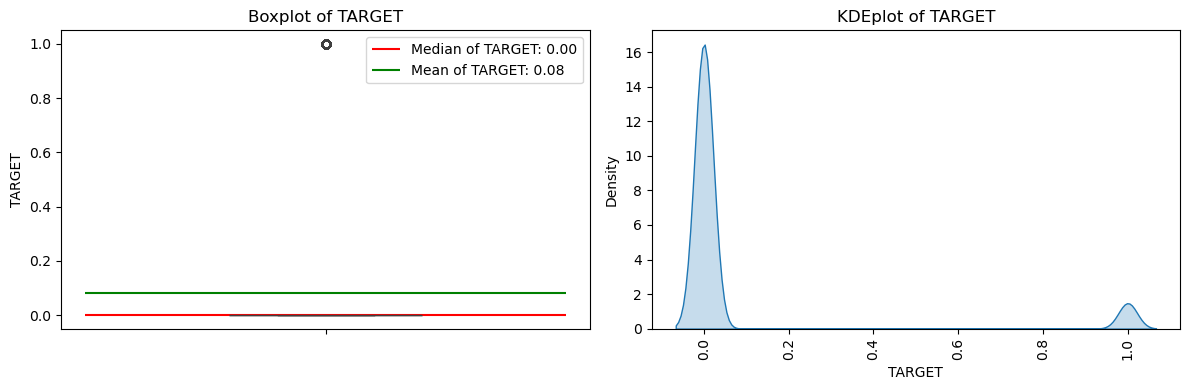

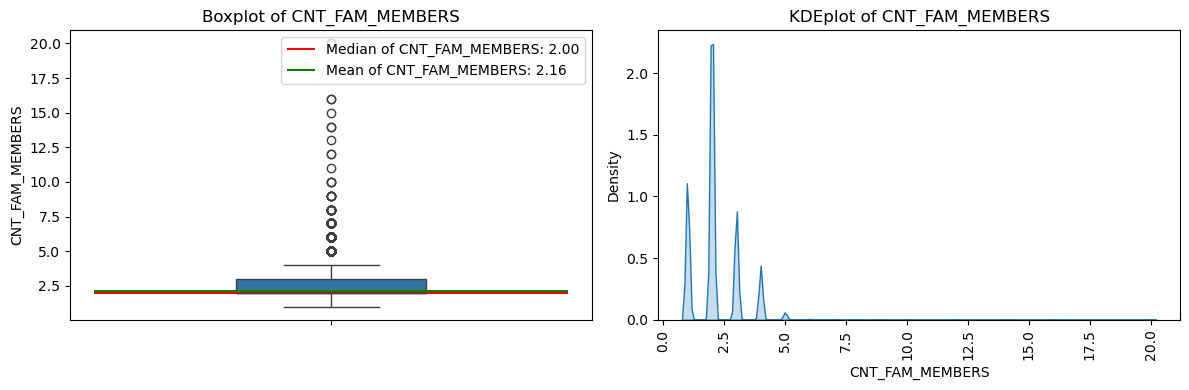

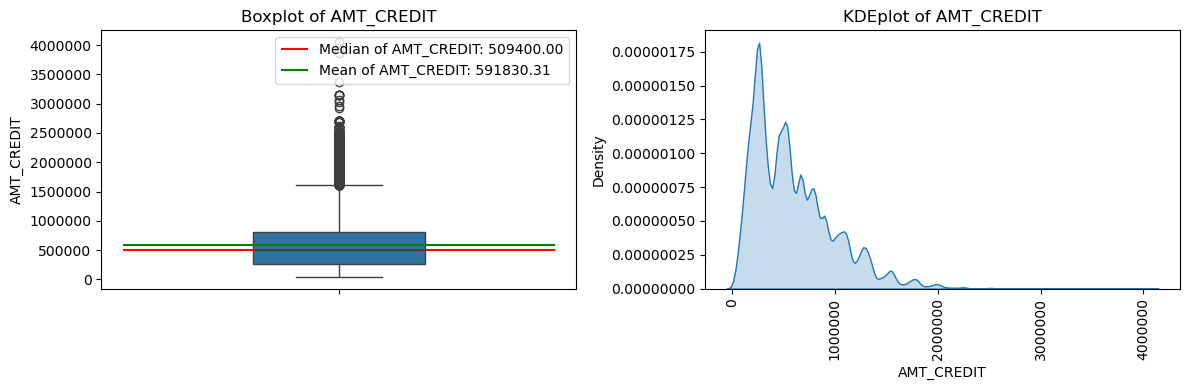

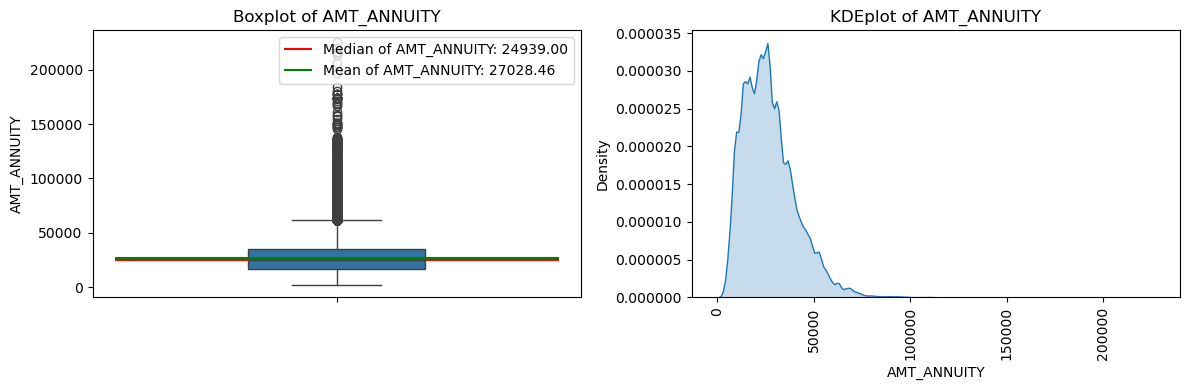

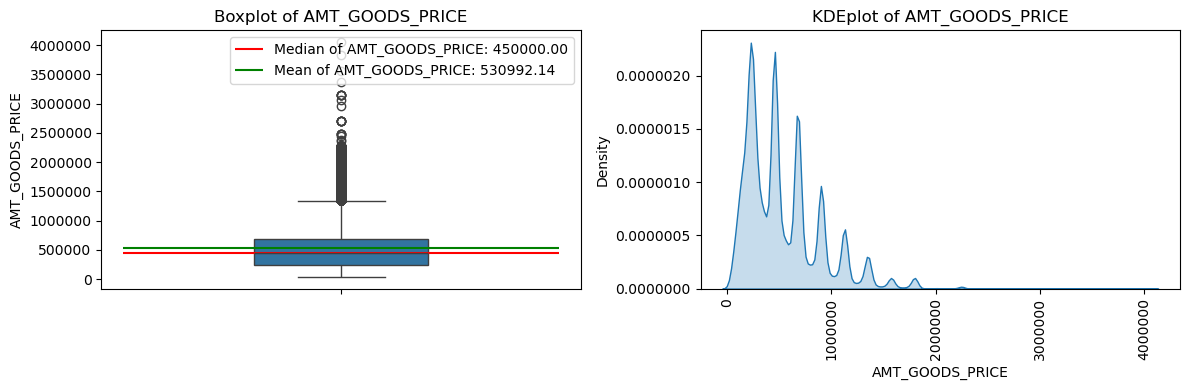

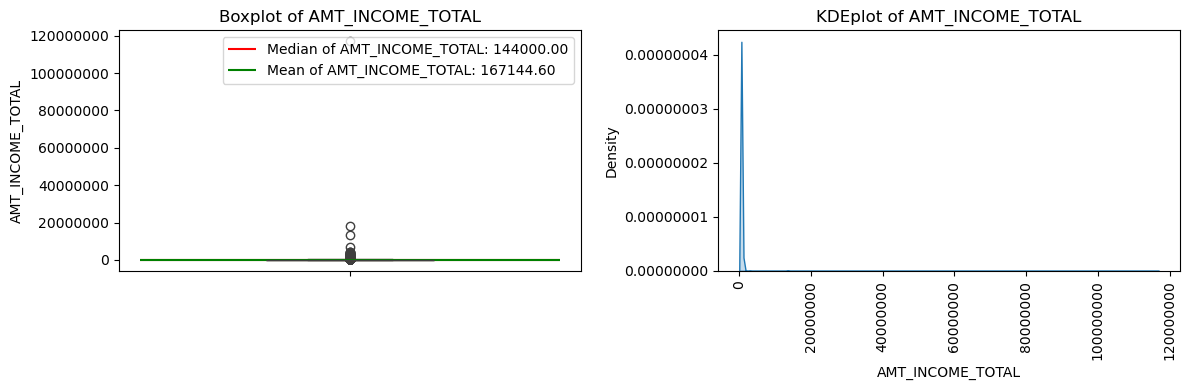

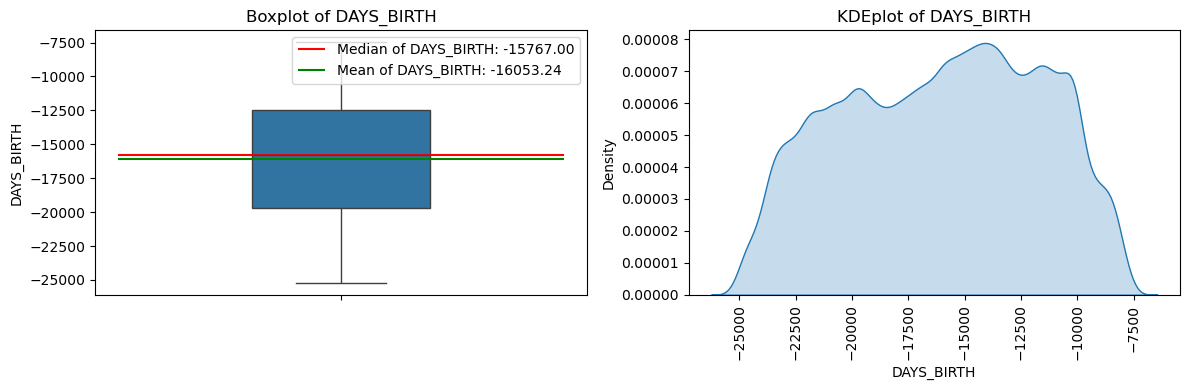

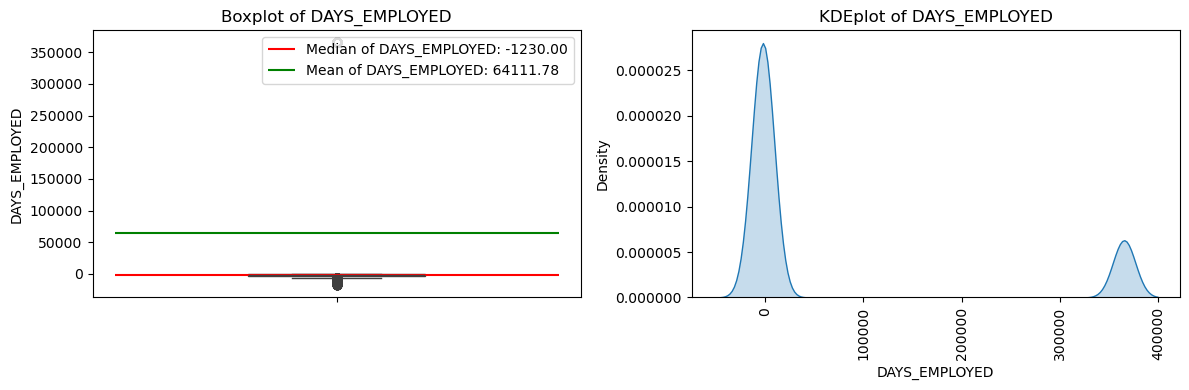

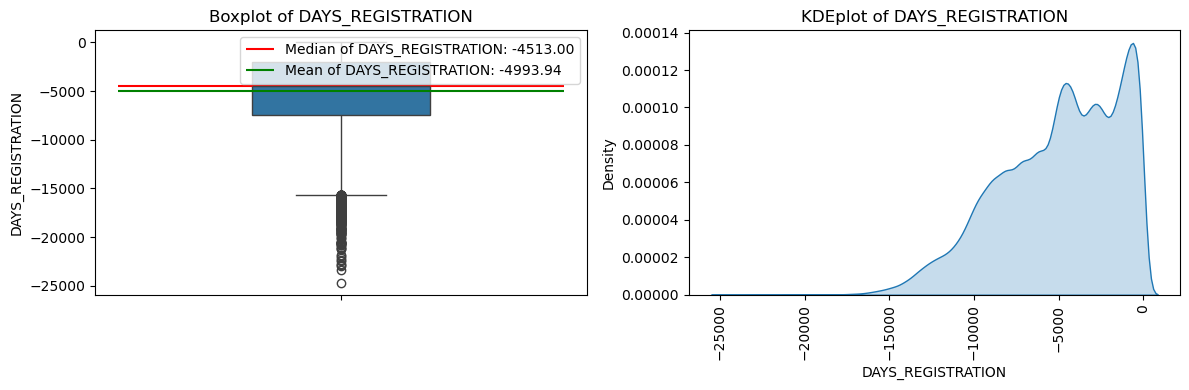

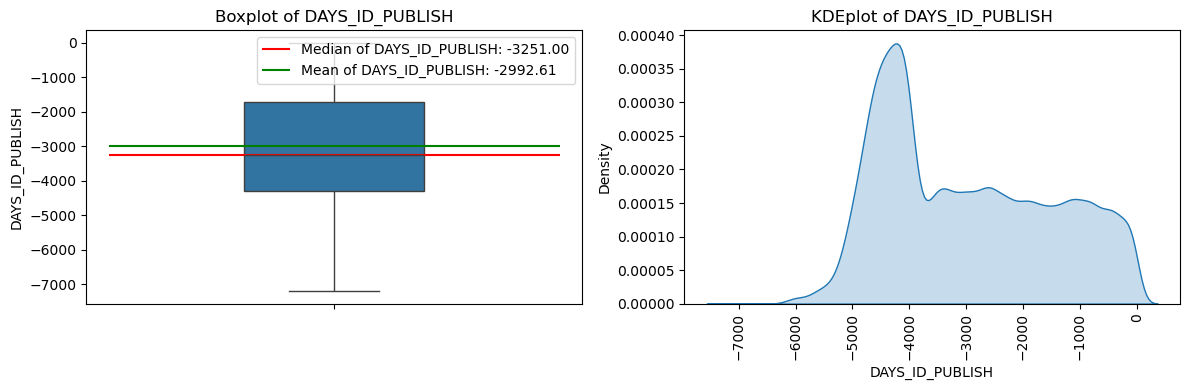

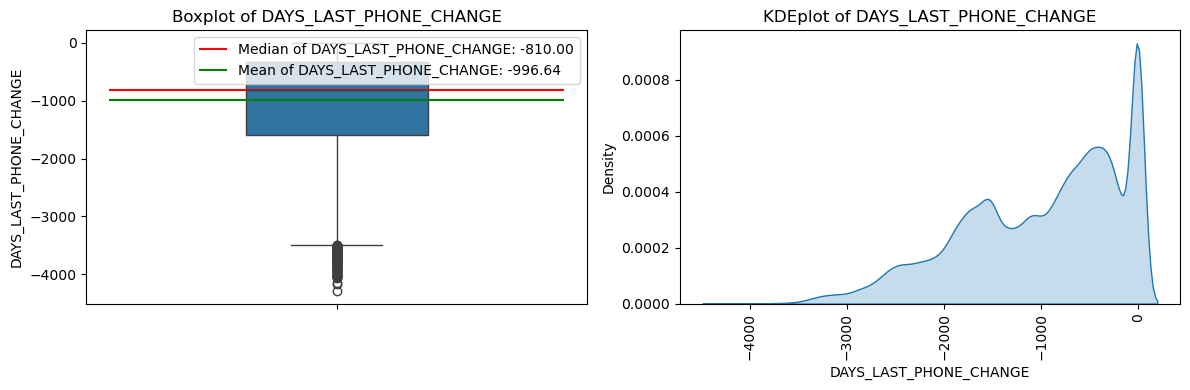

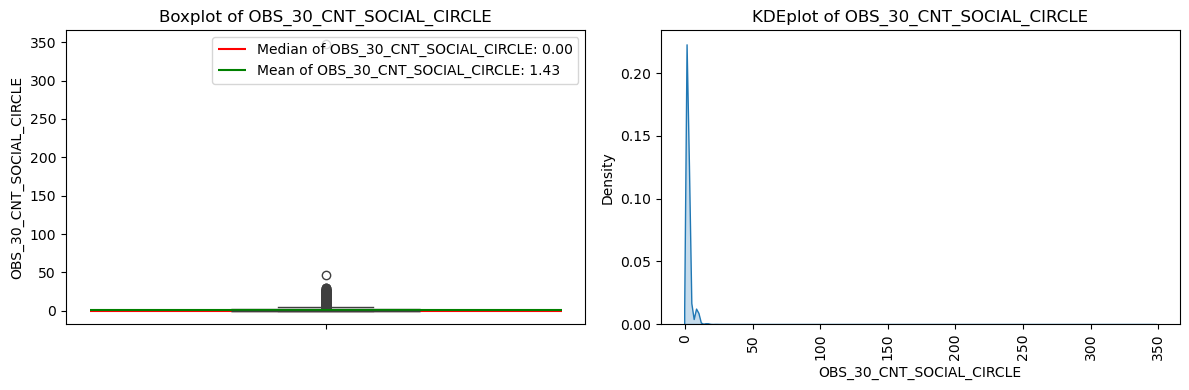

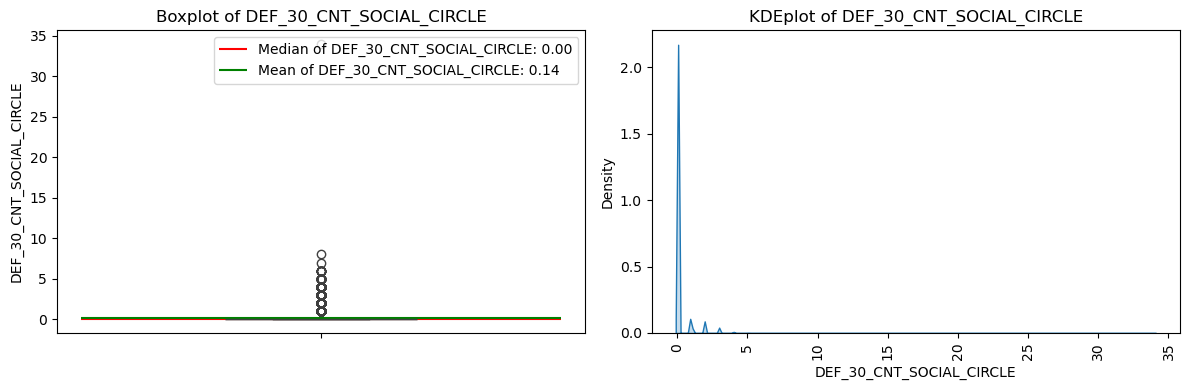

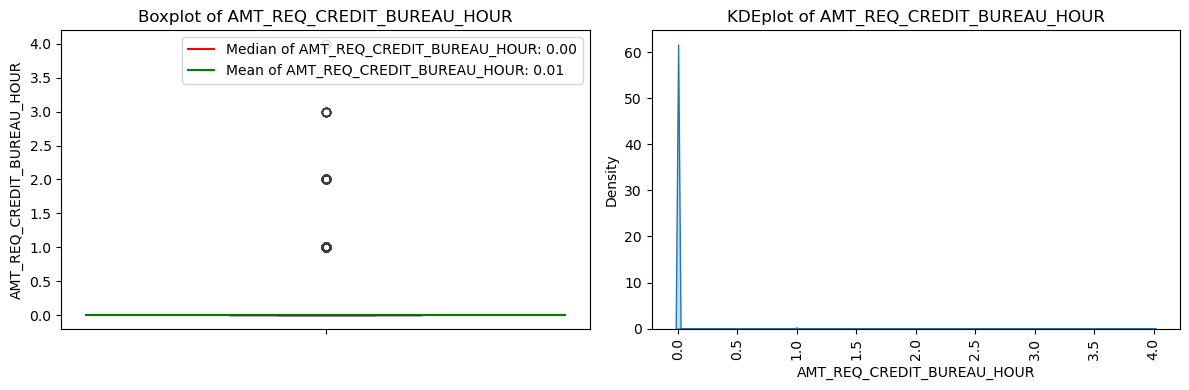

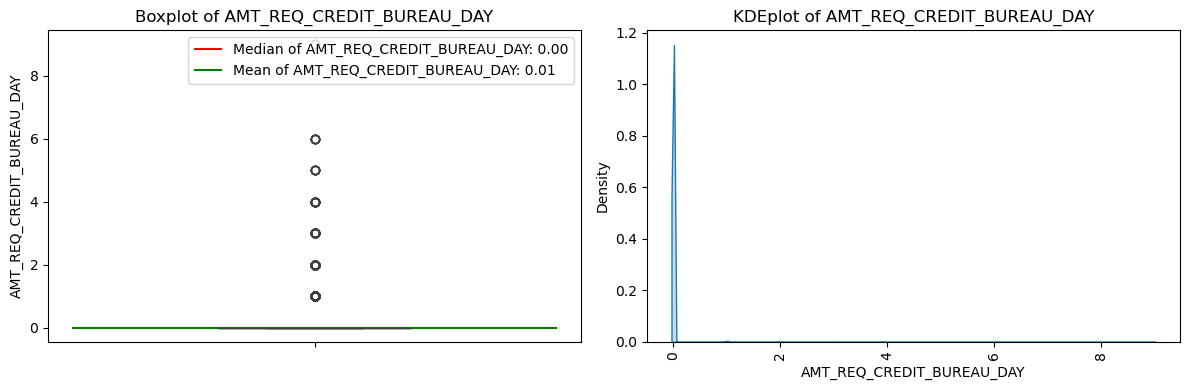

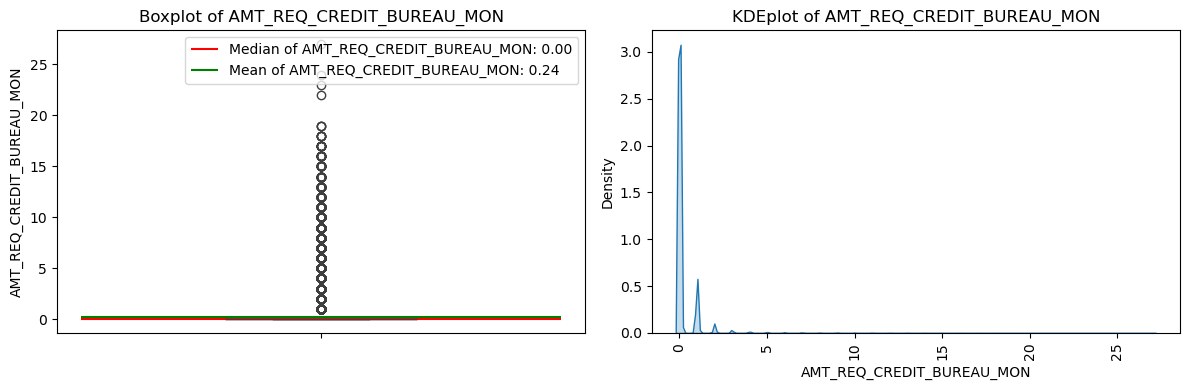

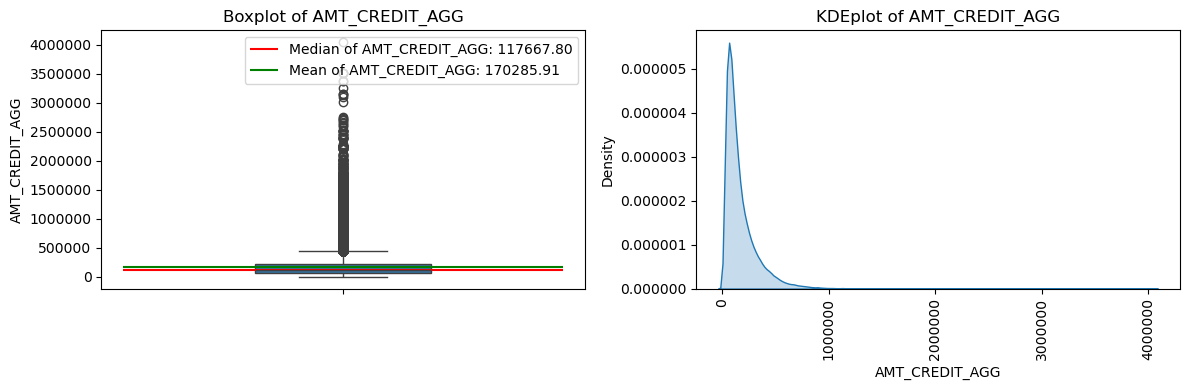

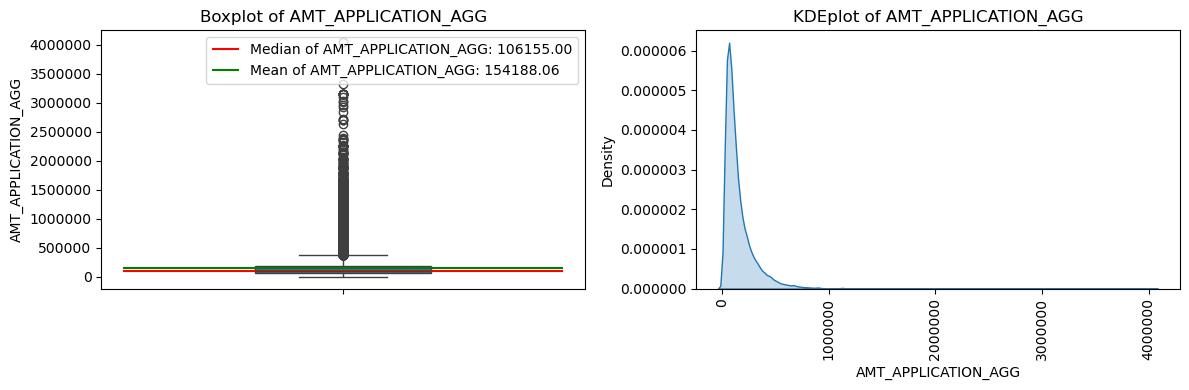

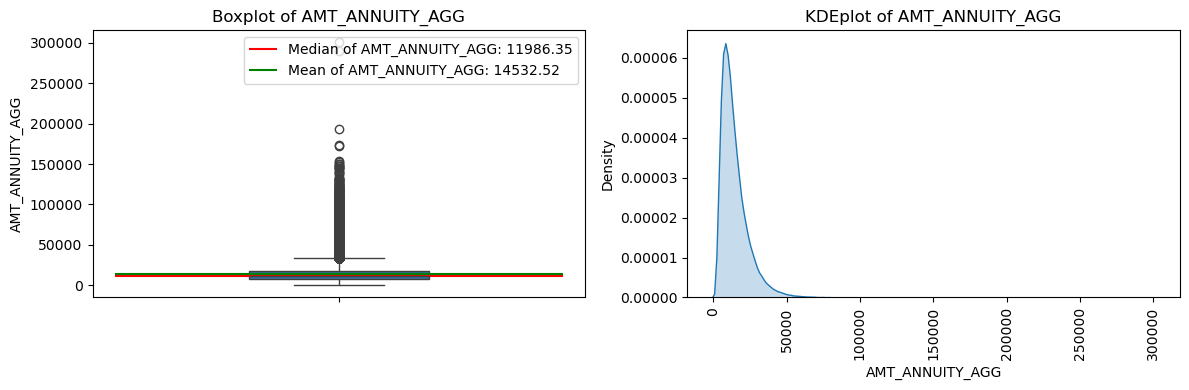

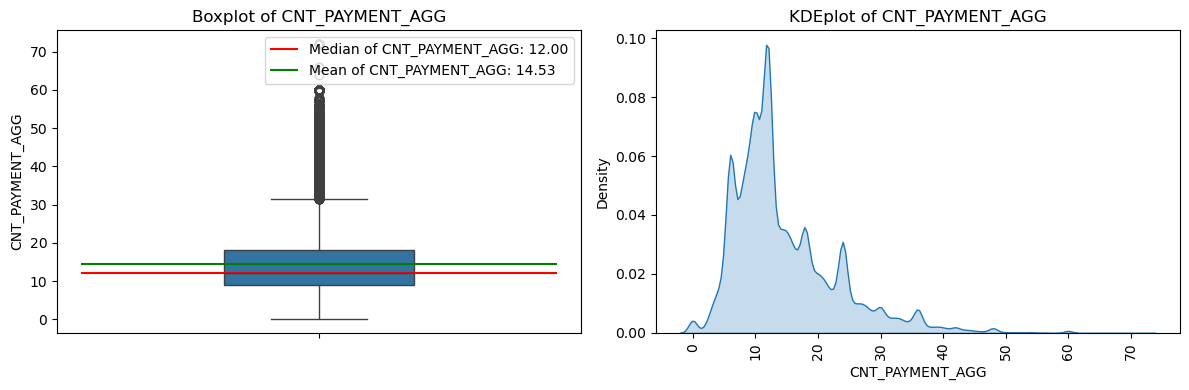

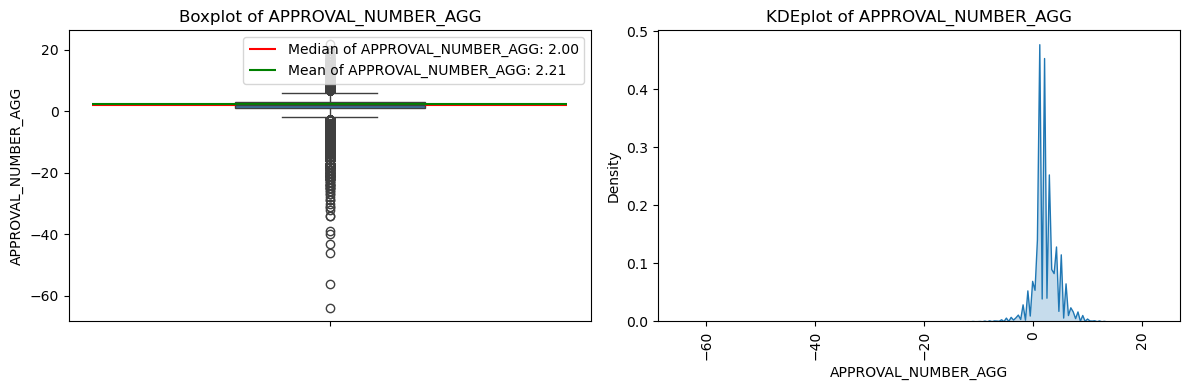

In [28]:
# looping through numerical columns except SK_ID_CURR
for column in num_column[1:]:
    # size of the total figure
    plt.figure(figsize=(12, 4))
    
    
    plt.subplot(1,2,1)
    plt.title(f"Boxplot of {column}")
    plt.gca().ticklabel_format(style='plain', axis='both')  # 'plain' disables scientific notation
    sns.boxplot(df_merged[column])
    plt.hlines(y=df_merged[column].median(), xmin=-1, xmax=1, label = f"Median of {column}: {df_merged[column].median():.2f}", color="red")
    plt.hlines(y=df_merged[column].mean(), xmin=-1, xmax=1, label = f"Mean of {column}: {df_merged[column].mean():.2f}", color="green")
    
    plt.legend(loc="upper right")
    plt.xticks(rotation=90)

    plt.subplot(1,2,2)
    plt.title(f"KDEplot of {column}")
    plt.gca().ticklabel_format(style='plain', axis='both')  # 'plain' disables scientific notation
    sns.kdeplot(df_merged[column], fill=True)
    
    plt.xticks(rotation=90)

    plt.tight_layout()
    # plt.savefig(f"{column}.png", bbox_inches='tight')     # this is for the ppt
    plt.show()
    

In [29]:
# looking at column description for better insight
# column_name("AMT_CREDIT")


In [30]:
# to get the column name
# num_column

<u> **OBSERVATION:**
From the above Boxplots and Kernel Density Estimation(KDE) plot we get:
>
> 1. CNT_FAM_MEMBERS: In boxplot, the mean and median are quite close (2 members) and are nearer to 25th percentile. This can be confirmed from looking at KDE. Also, the graph shows that there are multiple peaks which coincides with the data being a descrete number.
> 2. AMT_CREDIT: This is the amount credited in the current application (for previous application refer to AMT_CREDIT_AGG). The median is Rs. 5_09_400/-. The count of amount credited, from KDE plot, can be seen to range between 0 to 2.
> 3. AMT_ANNUITY: The yearly annuity can be seen having median of Rs. 24_939/-. The distribution is also somewhat even.
> 4. AMT_GOODS_PRICE: KDE shows peaks in many areas, meaning there is some typical cost of goods for which loan is being taken. The boxplot shows median of Rs. 4_50_000.
> 5.  AMT_INCOME_TOTAL: The median income is Rs. 1_44_000. As the boxplot and KDE are unclear, this variable should be further examined.
> 6.  DAYS_BIRTH: From KDE we can see that the distribution of days birth is uniformly distributed. The median is (-15_767 i.e. (15_767 / 365) = 43.19 years old).
> 7.  DAYS_EMPLOYED: The median is -1230 i.e. (1230/365 = 3.37)  3.37 years.
> 8.  AMT_CREDIT_AGG: From the previous dataset, we can see the median of aggregated credit amount is Rs. 1_17_667.80/-.
> 9.  AMT_APPLICATION_AGG: From the previous dataset, median aggregate application amount : Rs. 1_06_155.00/-.
> 10.  AMT_ANNUITY_AGG: From previous dataset, median aggregated annuity: Rs. 11_986.35/-.
> 11.  CNT_PAYMENT_AGG: From previous dataset, the median aggregate of payment tenure is 12 months.
> 12.  APPROVAL_NUMBER_AGG: From previous dataset, this is the aggregate of approved vs rejected application of a client. Here, median of sum of approval(+1) vs rejection(-1) is 2. We can see from boxplot that there are many outliers who had multiple rejection of as mucn as 60+.

<u> **4.1.2. BARPLOT OF CATEGORICAL DATA**

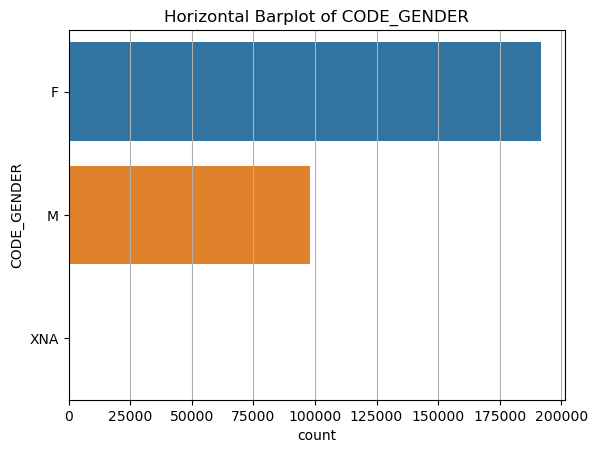

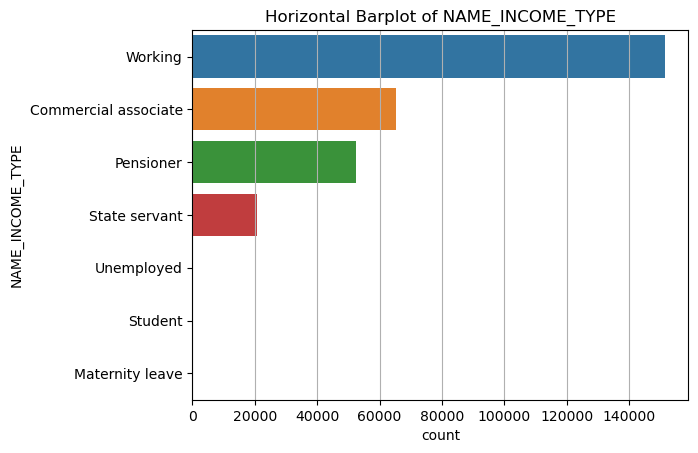

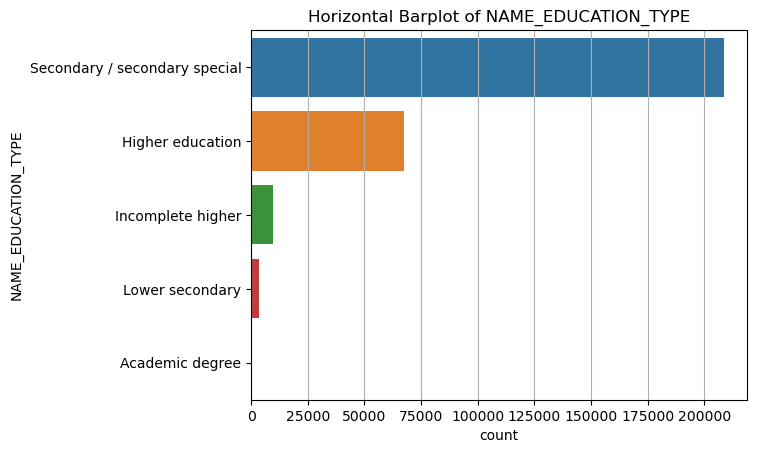

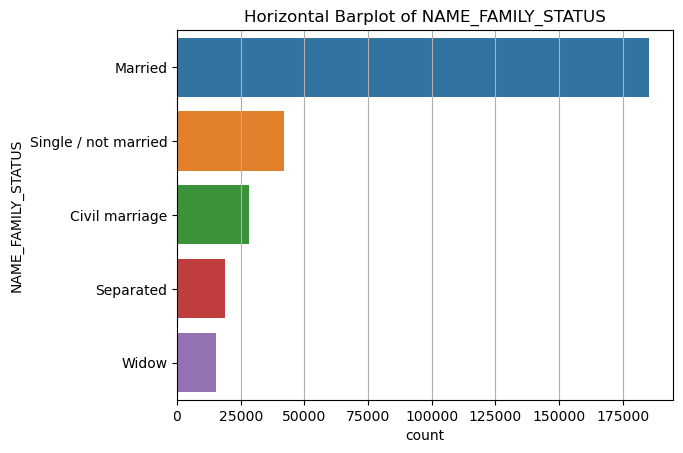

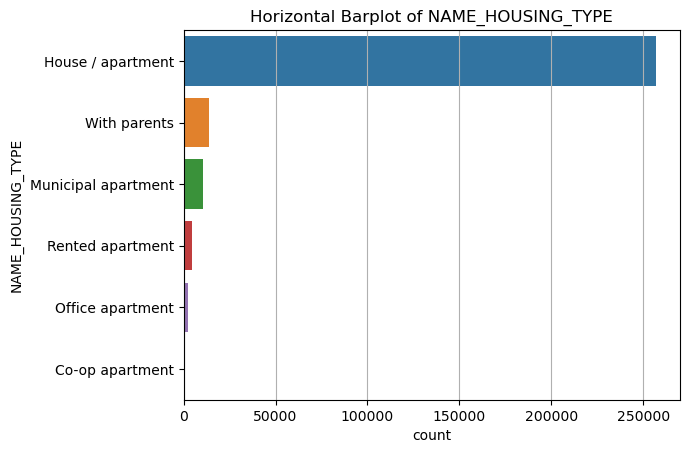

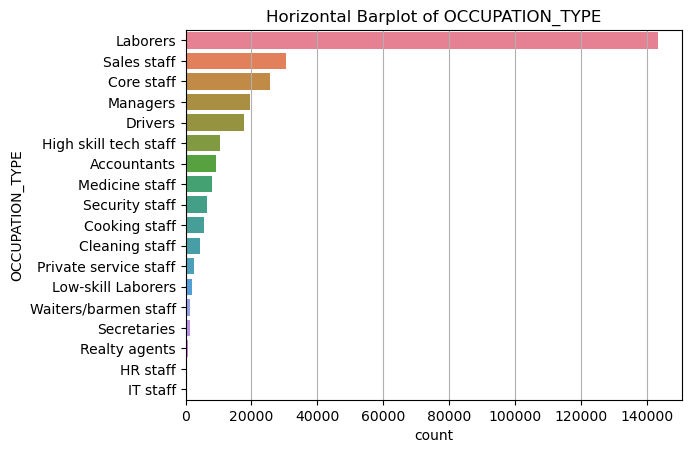

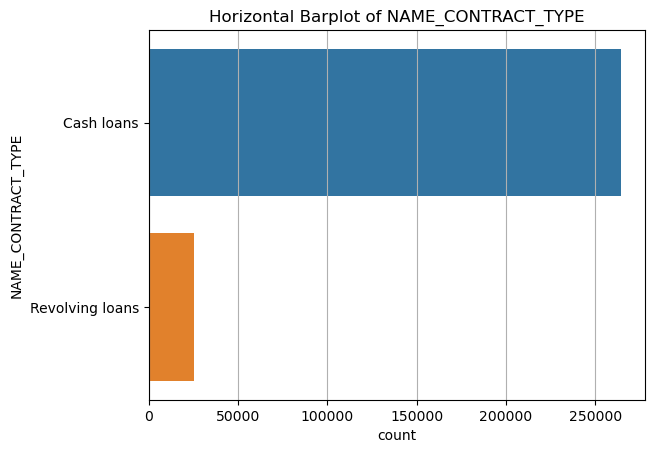

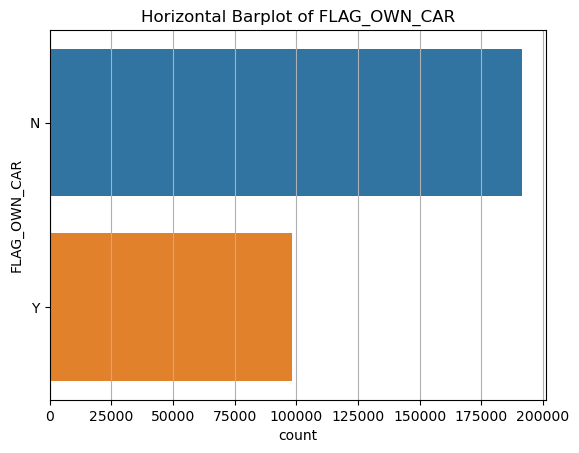

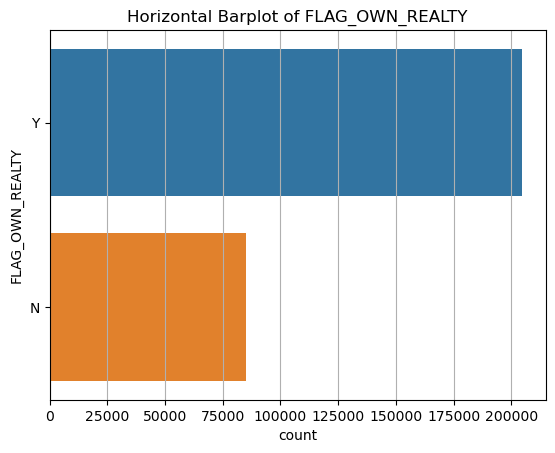

In [31]:
for column in cat_column:
    plt.title(f"Horizontal Barplot of {column}")
    
    plt.gca().ticklabel_format(style='plain', axis='both')  # 'plain' disables scientific notation
    
    # grouping by value counts and converting into dataframe
    grp_df = pd.DataFrame(df_merged[column].value_counts())
    sns.barplot(data=grp_df, x="count", y=grp_df.index, hue=grp_df.index) 
    plt.grid(axis="x")
    # plt.savefig(f"{column}.png", bbox_inches='tight')      # this is for the ppt
    plt.show()

In [32]:
# cross verifying the meaning with description
# column_name("FLAG_OWN_REALTY")

In [33]:
# looking at categorical columns names
# cat_column

<u> **OBSERVATION:**
From Bargraph count of categorical data who applied for loan:
>
> 1. CODE_GENDER: We can see that the female applicant in this dataset is double of that of male.
> 2. NAME_INCOME_TYPE: The count of "Working" category is highest who applied for loan.
> 3. NAME_FAMILY_STATUS: The count of married persons are higher compared to all other category by significant amount.
> 4. NAME_HOUSING_TYPE: The count of clients living in House/apartment is hugely higher than the rest of categories.
> 5. OCCUPATION_TYPE: Interestingly, clients of labourer category are of significantly highest count who applied for loan.
> 6. NAME_CONTRACT_TYPE: Maximum loans taken are of cash.
> 7. FLAG_OWN_CAR: Of those, applying about double of the applicants don't have car.
> 8. FLAG_OWN_REALTY: But interestingly, more than double of the people owns a house or flat.

#### **4.2. BIVARIATE AND MULTIVARIATE ANALYSIS**

<u> **4.2.1 HEATMAP OF CORRELATION BETWEEN ALL COLUMNS**

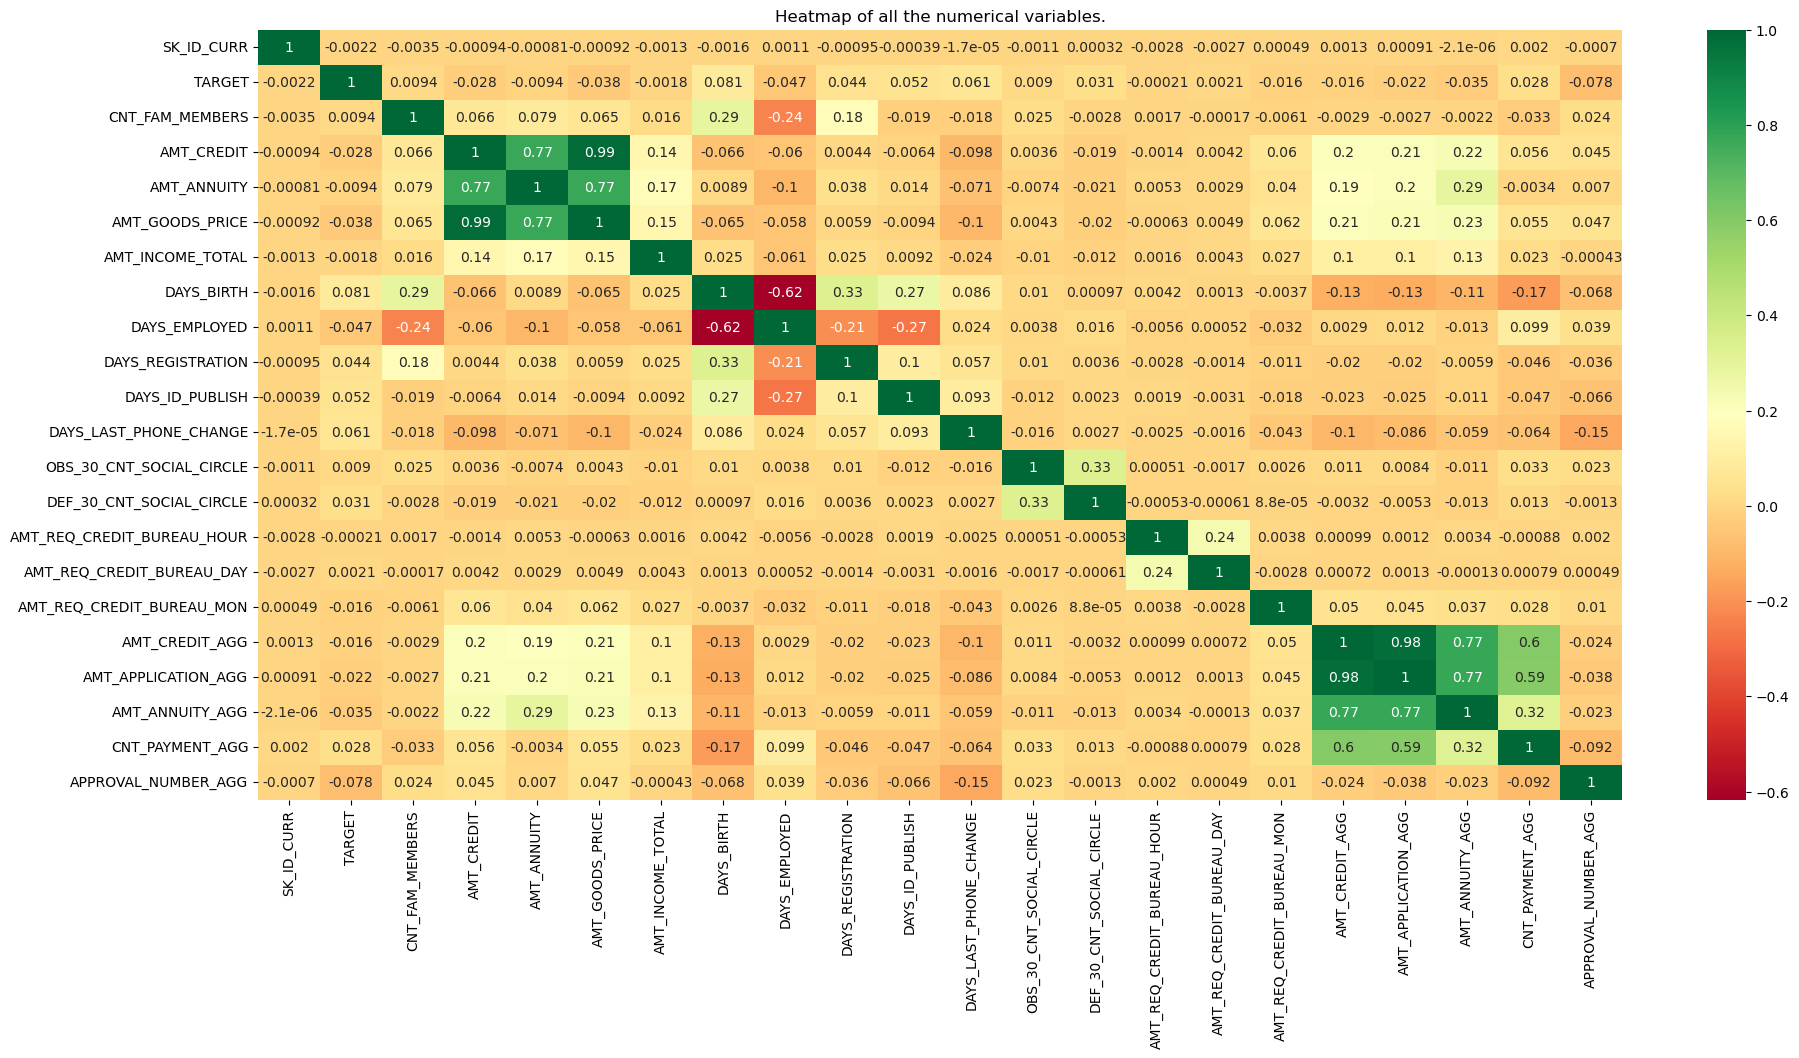

In [34]:
# storing correlation of numerical data in a variable
corr_matrix = df_merged[num_column].corr()

# plotting the correlation matrix as a heatmap
plt.figure(figsize=(22, 10))
plt.title("Heatmap of all the numerical variables.")
sns.heatmap(corr_matrix, cmap="RdYlGn", annot=True)
# plt.savefig("Heatmap.png", bbox_inches='tight')     # for ppt
plt.show()

<u> **OBSERVATION:**
From the heatmap we can see that:
>
> 1. AMT_GOODS_PRICE and AMT_CREDIT; AMT_APPLICATION_AGG and AMT_CREDIT_AGG have the highest correlation. This is obvious as the bank will lend the same amount as requested by the client.
> 2. Next correlation can be found between AMT_CREDIT and AMT_ANNUITY; AMT_CREDIT_AGG and AMT_ANNUITY_AGG; AMT_GOODS_PRICE and AMT_ANNUITY. This is also reasonable as the annuity one needs to pay is directly proportional to total amount credited.

<u> **4.2.2. MULTIVARIATE ANALYSIS OF "TARGET".**


**PAIRPLOT OF COLUMNS WITH MAXIMUM CORRELATION AND TARGET VARIABLE**

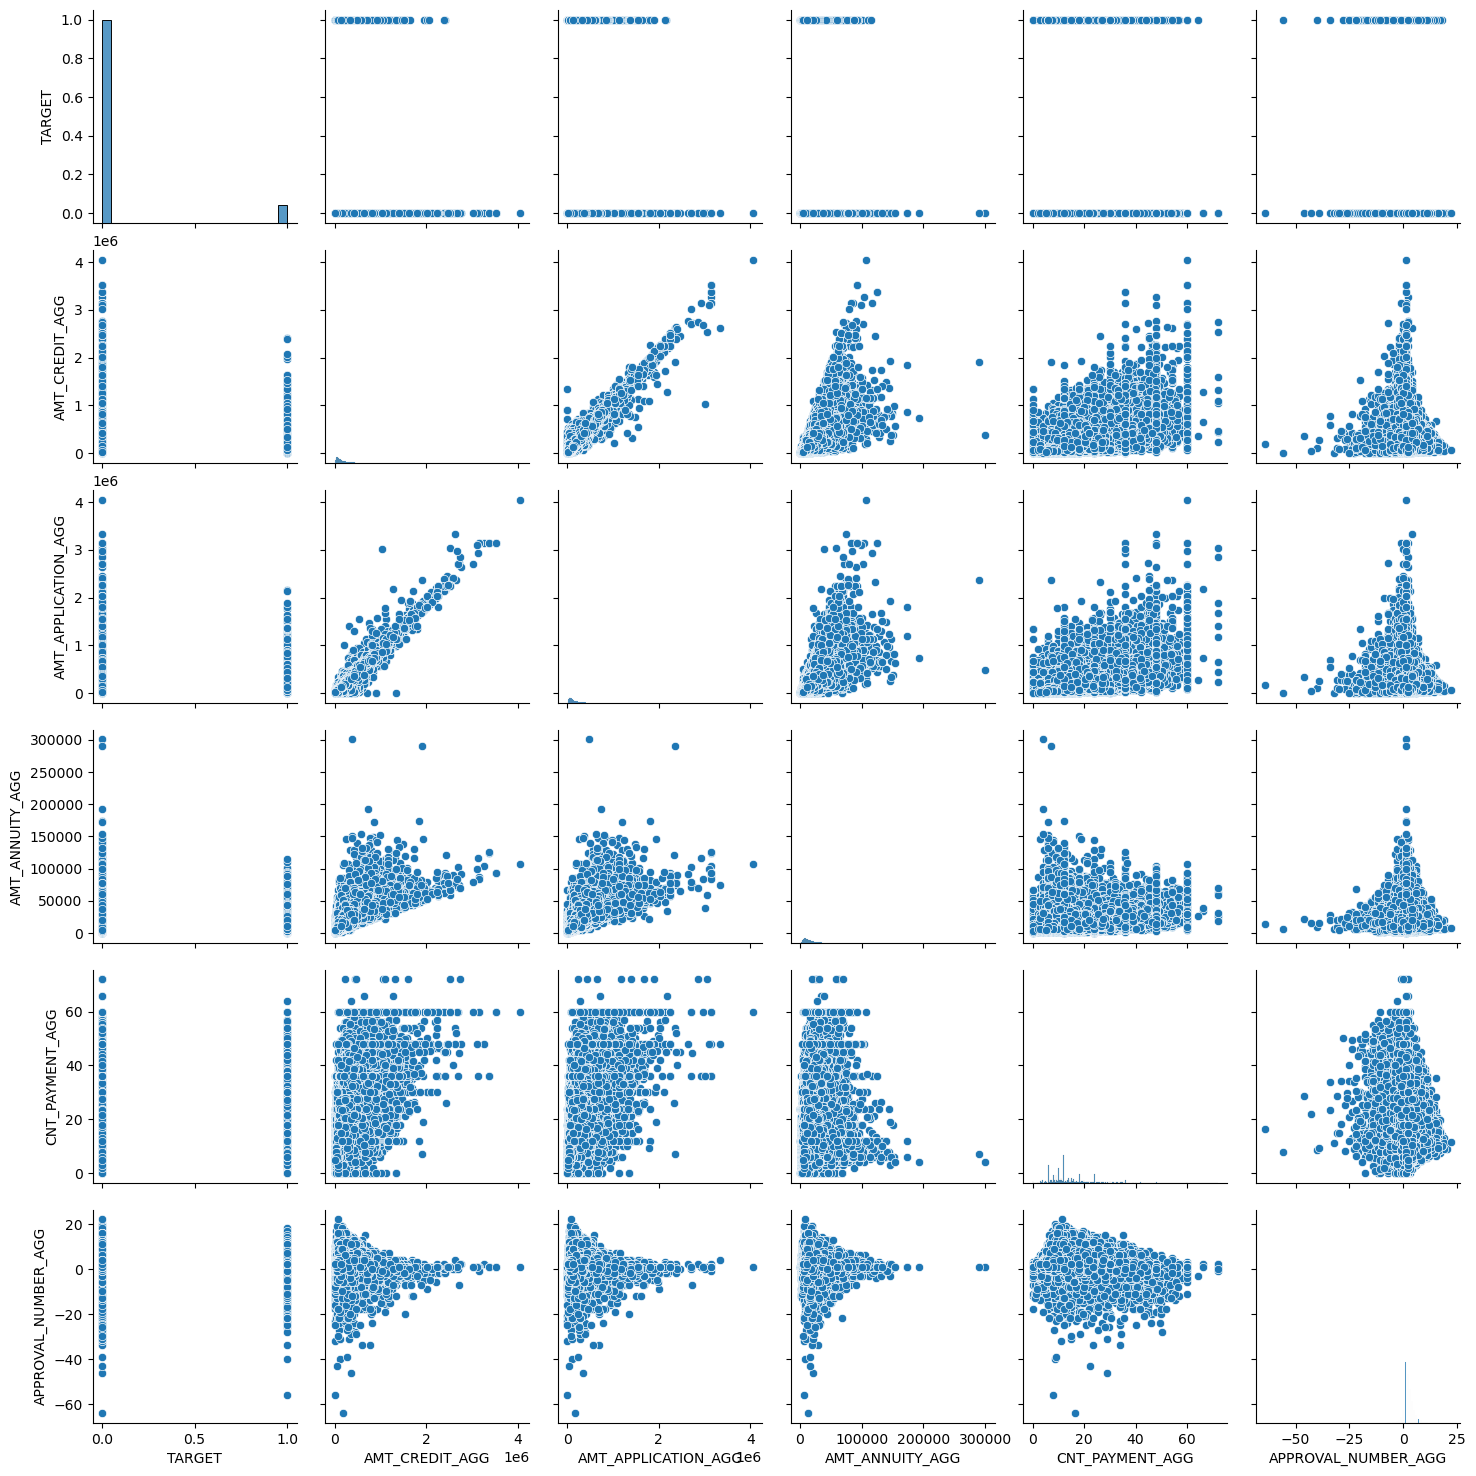

In [35]:
# now let's have a look at the column with maximum correlation.
temp_col = ["TARGET", "AMT_CREDIT_AGG", "AMT_APPLICATION_AGG", "AMT_ANNUITY_AGG", "CNT_PAYMENT_AGG", "APPROVAL_NUMBER_AGG"]
sns.pairplot(df_merged[temp_col])
# plt.savefig("Pairplot_corr_vs_target.png", bbox_inches='tight')     # for ppt
plt.show()

In [36]:
# lets look at the target variable description
# column_name("TARGET")

In [37]:
# categorical column
# cat_column

**SCATTERPLOT** OF ALL THE **CLIENTS** VS **INCOME TYPES** VS **POTENTIAL DEFAULTERS i.e. "TARGET"**

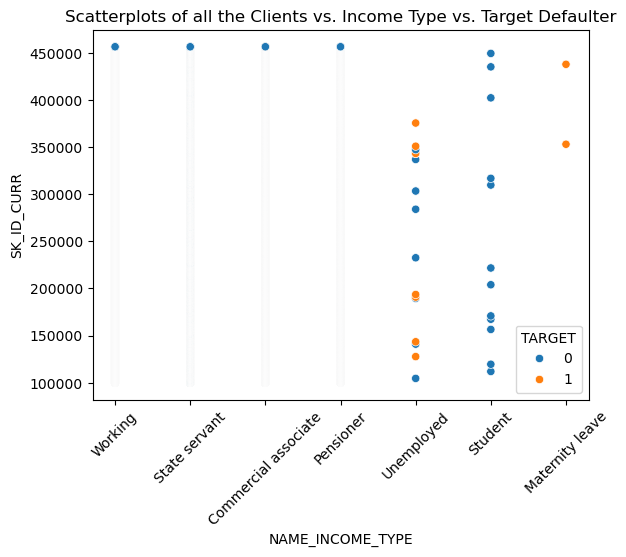

In [38]:

plt.title("Scatterplots of all the Clients vs. Income Type vs. Target Defaulter")
sns.scatterplot(data=df_merged, x="NAME_INCOME_TYPE", y="SK_ID_CURR", hue="TARGET")
# plt.savefig("scatterplot_client_income_vs_defaulter.png")       # for ppt
plt.xticks(rotation=45)
plt.show()

**OBSERVATION:** From the above scatterplot we can see that the bank has tagged most of the defaulters from "Unemployed" category and few of the "Maternity Leave" category.

**Now let's look further by plotting barplot of counts of clients, segmented by income type who are Defaulters.**

In [39]:
# creating series of groups based on income type and calculating the defaulters.
tar_1 = df_merged.groupby("NAME_INCOME_TYPE")["TARGET"].sum()  # defaulters count
tar_total = df_merged.groupby("NAME_INCOME_TYPE")["NAME_INCOME_TYPE"].count()  # total clients


In [40]:
defaulter_pct = (tar_1 / tar_total) * 100
defaulter_pct_df = pd.DataFrame(defaulter_pct, columns=["Percentage"])
defaulter_pct_df          # percentage of defaulter in this dataset

,Percentage
NAME_INCOME_TYPE,
Commercial associate,7.732560
Maternity leave,100.000000
Pensioner,5.396995
State servant,5.803094
Student,0.000000
Unemployed,50.000000
Working,9.704065


**PIE CHART OF DEFAULTERS SEGMENTED BY TYPE OF INCOME**

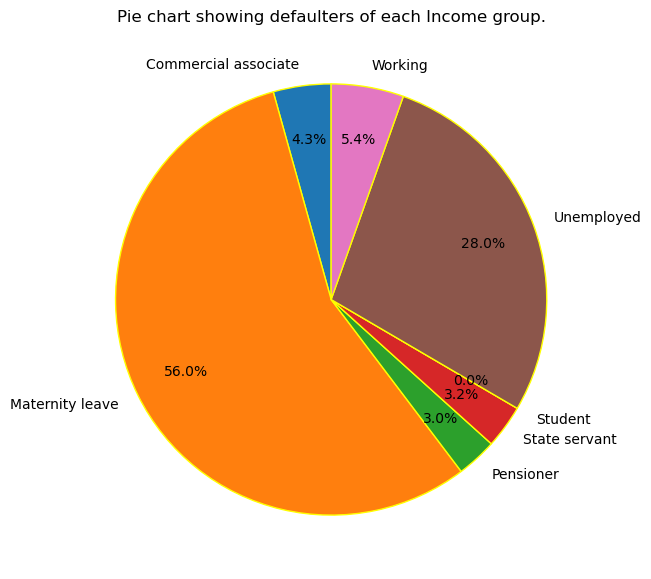

In [41]:
plt.figure(figsize=(7,7))
plt.title("Pie chart showing defaulters of each Income group.")
plt.pie(x=defaulter_pct_df["Percentage"], labels=defaulter_pct_df.index, autopct='%1.1f%%', startangle=90, pctdistance=0.75, wedgeprops={'edgecolor': 'yellow'})
# plt.savefig("Defaulters_income_type_pie.png")     # for ppt
plt.show()

**OBSERVATION:**
> This confirms that the maximum defaulter in the dataset are "Unemployed" and "Maternity leave".

# **CONCLUSION:** 
#### FROM THE EDA WE GOT TO KNOW THAT MULTIPLE FACTORS CAN INFLUENCE DEFAULTING TENDENCY, PARTICULARLY THE CLIENTS WHO ARE IN UNEMPLOYED GROUP, THE BANK TEND TO HESITATE TO GIVE ANY LOAN.